<a href="https://colab.research.google.com/github/Riiishaab/OS-Detection-/blob/main/OS_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Latest Version of TensorFlow

In [ ]:
!pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.17.0 requires tensorflow<2.18,>=2.17.0, but you have tensorflow 2.18.0 which i

# Image Fetching and Split

In [ ]:
import cv2
import os
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for classes (Normal, Osteopenia, and Osteoporosis)
dataset_paths = {
    'Normal': '/content/drive/MyDrive/OS Dataset/Normal/',
    'Osteopenia': '/content/drive/MyDrive/OS Dataset/Osteopenia/',
    'Osteoporosis': '/content/drive/MyDrive/OS Dataset/Osteoporosis/'
}

# Function to load images and labels
def load_images_and_labels(folder_path, label, target_size=(128, 128)):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):  # Sort filenames for consistent order
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):  # Check for valid image files
            img_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(img_path)  # Load the image
                if img is not None:  # Check if the image is loaded successfully
                    img = cv2.resize(img, target_size)  # Resize the image
                    if len(img.shape) == 2:  # If grayscale, convert to 3-channel
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                    img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img)  # Add the processed image
                    labels.append(label)  # Add the corresponding label
                else:
                    print(f"Error loading image: {img_path}")  # Print error if image could not be loaded
            except Exception as e:
                print(f"Exception loading image {img_path}: {e}")  # Log any exceptions
        else:
            print(f"Skipping non-image file: {filename}")  # Skip non-image files
    return np.array(images), np.array(labels)

# Load and combine images and labels for all classes
normal_images, normal_labels = load_images_and_labels(dataset_paths['Normal'], label=0)
osteopenia_images, osteopenia_labels = load_images_and_labels(dataset_paths['Osteopenia'], label=1)
osteoporosis_images, osteoporosis_labels = load_images_and_labels(dataset_paths['Osteoporosis'], label=2)

# Combine images and labels from all classes
combined_images = np.concatenate([normal_images, osteopenia_images, osteoporosis_images], axis=0)
combined_labels = np.concatenate([normal_labels, osteopenia_labels, osteoporosis_labels], axis=0)

# Print dataset details
print(f"Normal images: {normal_images.shape[0]}, Osteopenia images: {osteopenia_images.shape[0]}, Osteoporosis images: {osteoporosis_images.shape[0]}")
print(f"Total images: {combined_images.shape[0]}, Total labels: {combined_labels.shape[0]}")

# Shuffle the dataset
indices = np.arange(combined_images.shape[0])  # Generate indices for the dataset
np.random.seed(42)  # Set seed for reproducibility
np.random.shuffle(indices)  # Shuffle the indices
combined_images = combined_images[indices]  # Shuffle images
combined_labels = combined_labels[indices]  # Shuffle corresponding labels

# Final data ready for model input
x_data, y_data = combined_images, combined_labels
print(f"Total images (Check after shuffling): {x_data.shape[0]}")
print(f"Image shape: {x_data.shape[1:]}")
print(f"Labels shape: {y_data.shape}")

# Configurable split ratios
test_ratio = 0.3  # Fraction of the dataset for testing
validation_ratio = 0.1  # Fraction of the training+validation dataset for validation

# Split data into training+validation and test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data, test_size=test_ratio, random_state=42, stratify=y_data)

# Split the training+validation set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=validation_ratio, random_state=42, stratify=y_train_val)

# Print dataset sizes
print(f"Training set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Test set: {x_test.shape[0]} samples")

# Print class distributions for sanity check
print("Class distribution in Training set:", np.bincount(y_train))
print("Class distribution in Validation set:", np.bincount(y_val))
print("Class distribution in Test set:", np.bincount(y_test))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Normal images: 780, Osteopenia images: 374, Osteoporosis images: 793
Total images: 1947, Total labels: 1947
Total images (Check after shuffling): 1947
Image shape: (128, 128, 3)
Labels shape: (1947,)
Training set: 1225 samples
Validation set: 137 samples
Test set: 585 samples
Class distribution in Training set: [491 235 499]
Class distribution in Validation set: [55 26 56]
Class distribution in Test set: [234 113 238]


# Model

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define Focal Loss for multi-class classification (with sparse labels)
def focal_loss_multi_class(gamma=2., alpha=None):
    def focal_loss_fixed(y_true, y_pred):
        # One-hot encode y_true
        y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=3)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())  # Prevent log(0)
        cross_entropy = -y_true * K.log(y_pred)
        if alpha is not None:
            alpha_factor = K.sum(y_true * K.constant(alpha), axis=-1)
            cross_entropy *= alpha_factor
        weight = K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

# Build a Transfer Learning Model using InceptionV3
def build_model(input_shape, num_classes):
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    inputs = layers.Input(shape=input_shape)

    # Pass inputs through the pre-trained model
    x = base_model(inputs, training=False)

    # Global Average Pooling to reduce the feature maps
    x = layers.GlobalAveragePooling2D()(x)

    # Batch Normalization for better training stability
    x = layers.BatchNormalization()(x)

    # Dense layers for multi-class classification
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)  # Regularization

    # Output layer with softmax for multi-class classification
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model with Focal Loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=focal_loss_multi_class(gamma=2.),
        metrics=['accuracy', 'categorical_accuracy']
    )

    return model

# Define input shape and number of classes
input_shape = (128, 128, 3)
num_classes = 3

# Build and summarize the model
transfer_model = build_model(input_shape, num_classes)
transfer_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,074,147 (84.21 MB)

 Trainable params: 2,202,371 (8.40 MB)

 Non-trainable params: 19,871,776 (75.80 MB)

# Training

In [ ]:

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Print note about the learning rate scheduler
print("Learning Rate Scheduler (ReduceLROnPlateau) is configured.")

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator()

# Generate augmented training data
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=32,
    shuffle=True
)

# Generate validation data
val_generator = val_test_datagen.flow(
    x_val, y_val,
    batch_size=32,
    shuffle=False
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Learning Rate Scheduler (ReduceLROnPlateau) is configured.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5010 - categorical_accuracy: 0.2789 - loss: 1.2718 - val_accuracy: 0.5693 - val_categorical_accuracy: 0.2555 - val_loss: 1.4517 - learning_rate: 0.0010
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5752 - categorical_accuracy: 0.2952 - loss: 0.7528 - val_accuracy: 0.5839 - val_categorical_accuracy: 0.2920 - val_loss: 1.0000 - learning_rate: 0.0010
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6282 - categorical_accuracy: 0.2825 - loss: 0.5983 - val_accuracy: 0.5839 - val_categorical_accuracy: 0.2117 - val_loss: 0.5742 - learning_rate: 0.0010
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6023 - categorical_accuracy: 0.1959 - loss: 0.6423 - val_accuracy: 0.6496 - val_categorical_accuracy: 0.2117 - val_loss: 0.5444 - learning_rate: 0.0010
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6373 - categorical_accuracy: 0.3124 - loss: 0.5573 - val_accuracy: 0.686

# Evaluation

19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


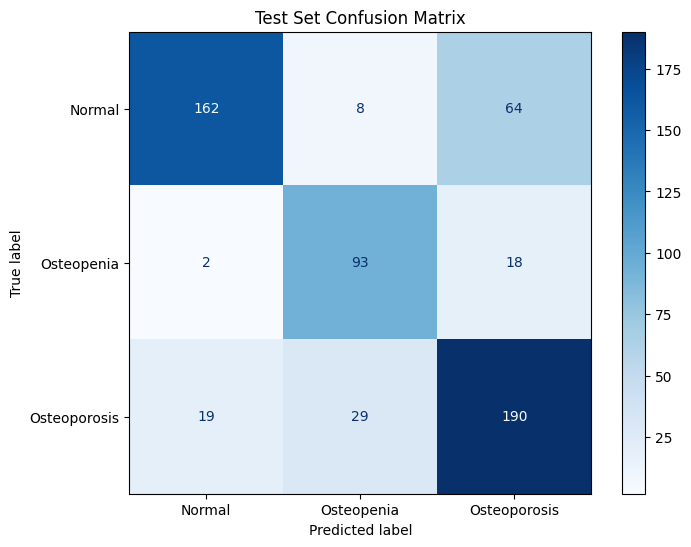

Test Set Metrics:
Accuracy: 0.7607
Precision: 0.7765
Recall: 0.7607
F1 Score: 0.7618
Confusion Matrix:
[[162   8  64]
 [  2  93  18]
 [ 19  29 190]]
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


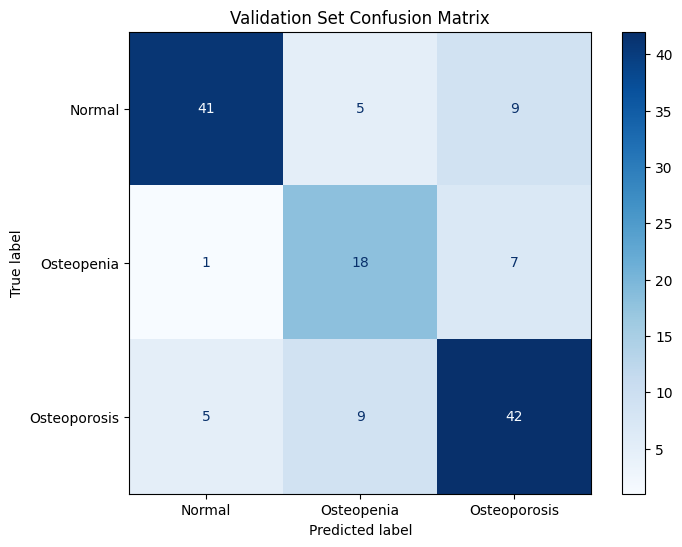

Validation Set Metrics:
Accuracy: 0.7372
Precision: 0.7530
Recall: 0.7372
F1 Score: 0.7417
Confusion Matrix:
[[41  5  9]
 [ 1 18  7]
 [ 5  9 42]]


In [ ]:
# Predict on the test set
test_predictions = transfer_model.predict(x_test)  # Predict probabilities for each class
test_pred_labels = np.argmax(test_predictions, axis=1)  # Convert softmax outputs to class indices

# Use test labels directly if they are already class indices
y_test_class_indices = y_test

# Plot confusion matrix for the test set
plot_confusion_matrix(
    y_test_class_indices,
    test_pred_labels,
    class_labels,
    title="Test Set Confusion Matrix"
)

# Evaluate model on the test set
print("Test Set Metrics:")
test_metrics = evaluate_model(y_test_class_indices, test_pred_labels)

# Predict on the validation set
val_predictions = transfer_model.predict(x_val)  # Predict probabilities for each class
val_pred_labels = np.argmax(val_predictions, axis=1)  # Convert softmax outputs to class indices

# Use validation labels directly if they are already class indices
y_val_class_indices = y_val  # Here we directly use y_val

# Plot confusion matrix for the validation set
plot_confusion_matrix(
    y_val_class_indices,
    val_pred_labels,
    class_labels,
    title="Validation Set Confusion Matrix"
)

# Evaluate model on the validation set
print("Validation Set Metrics:")
val_metrics = evaluate_model(y_val_class_indices, val_pred_labels)


# Graph

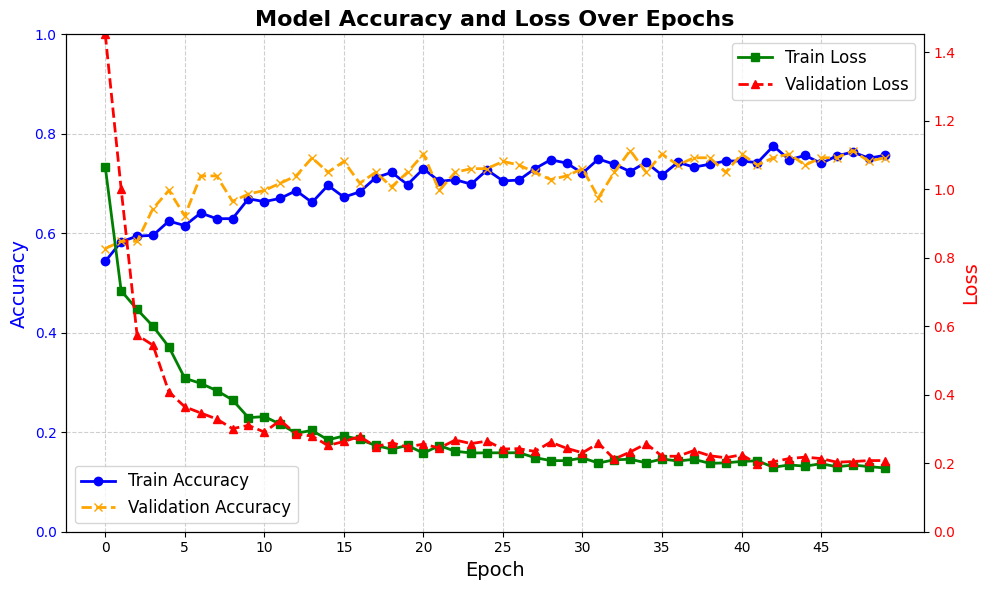

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
fig, ax1 = plt.subplots(figsize=(10, 6))  # Create figure and axis

# Plot Accuracy on primary y-axis
ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o', markersize=6, linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', marker='x', markersize=6, linewidth=2)

# Set labels for accuracy
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14, color='blue')
ax1.set_ylim(0, 1)  # Accuracy range from 0 to 1
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for loss
ax2 = ax1.twinx()
if 'loss' in history.history and 'val_loss' in history.history:
    ax2.plot(history.history['loss'], label='Train Loss', color='green', linestyle='-', marker='s', markersize=6, linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='^', markersize=6, linewidth=2)

# Set labels for loss
ax2.set_ylabel('Loss', fontsize=14, color='red')
ax2.set_ylim(0, max(history.history['loss'] + history.history['val_loss']))  # Set loss axis range based on data
ax2.tick_params(axis='y', labelcolor='red')

# Add title
plt.title('Model Accuracy and Loss Over Epochs', fontsize=16, weight='bold')

# Display grid with lighter style for better visualization
ax1.grid(True, linestyle='--', alpha=0.6)

# Customize x-axis to make it cleaner
plt.xticks(range(0, len(history.history['accuracy']), max(1, len(history.history['accuracy'])//10)), fontsize=12)

# Display legends for both accuracy and loss
ax1.legend(loc='lower left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping of labels
plt.show()
